<a href="https://colab.research.google.com/github/nargyanti/IPCV_Genap_2022/blob/main/Week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No 1 - Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# No 2 - Detect Several Face

In [43]:
# Detect face
def detect_face(haarcascade, image):  
  cascade_face = cv.CascadeClassifier(haarcascade)
  detected_image = image.copy()
  roi_face = cascade_face.detectMultiScale(detected_image)
  for(x,y,w,h) in roi_face:
    cv.rectangle(detected_image,(x,y),(x+w,y+h),(0,255,0),3)
  return detected_image

In [45]:
# Import image
jokowi = cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/jokowi.jpg'), cv.COLOR_RGB2BGR)
kartini = cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/kartini.jpg'), cv.COLOR_RGB2BGR)
kucing = cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/kucing.jpg'), cv.COLOR_RGB2BGR)
mask =cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/mask.png'), cv.COLOR_RGB2BGR)
mjordan = cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/mjordan.jpg'), cv.COLOR_RGB2BGR)
solvayconf = cv.cvtColor(cv.imread('/content/drive/MyDrive/PCVK/facedet/solvayconf.jpg'), cv.COLOR_RGB2BGR)

In [48]:
# Show image
def show_image(image, detected_image):
  plt.figure(figsize = (10,10))
  plt.subplot(221),plt.imshow(image)
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(222),plt.imshow(detected_image)
  plt.title('Face Detection'), plt.xticks([]), plt.yticks([])  
  plt.show()

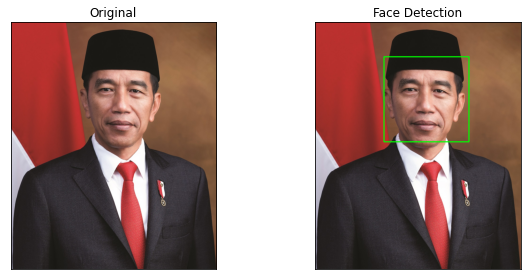

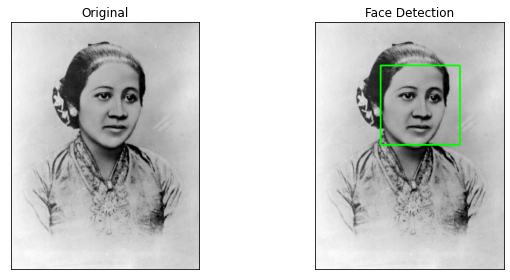

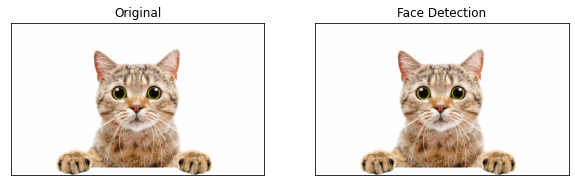

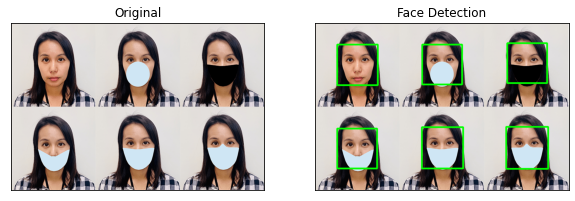

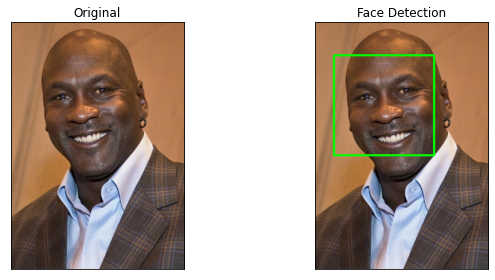

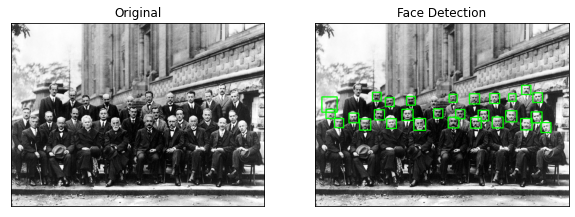

In [49]:
images = [jokowi, kartini, kucing, mask, mjordan, solvayconf]
for image in images:  
  haarcascade = '/content/drive/MyDrive/PCVK/haarcascades/haarcascade_frontalface_alt.xml' # Import haarcascade
  detected_image = detect_face(haarcascade, image)
  show_image(image, detected_image)

# No 3 - Detect Cat Face

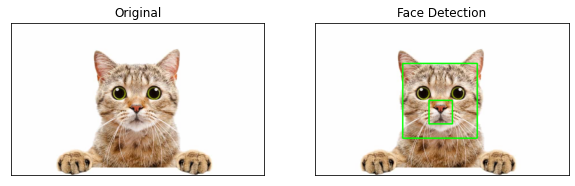

In [50]:
haarcascade = '/content/drive/MyDrive/PCVK/haarcascades/haarcascade_frontalcatface.xml'
detected_image = detect_face(haarcascade, kucing)
show_image(kucing, detected_image)

# No 4 - Detect eyes

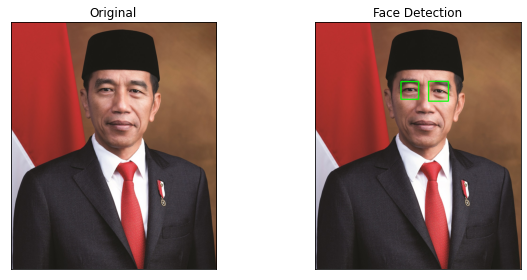

In [51]:
haarcascade = '/content/drive/MyDrive/PCVK/haarcascades/haarcascade_eye.xml'
detected_image = detect_face(haarcascade, jokowi)
show_image(jokowi, detected_image)

# No 5 - Detect Face using Webcam

In [113]:
# No 5 - Detect Face using Webcam
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [114]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv.imdecode(jpg_as_np, flags=1)
  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):  
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

In [115]:
# initialize the Haar Cascade face detection model
face_cascade = cv.CascadeClassifier('/content/drive/MyDrive/PCVK/haarcascades/haarcascade_frontalface_alt.xml')

In [118]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [117]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
      bbox_array = cv.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# No 6 - Blur face

In [90]:
def blur_face(haarcascade, image):  
  cascade_face = cv.CascadeClassifier(haarcascade)
  detected_image = image.copy()
  roi_face = cascade_face.detectMultiScale(detected_image)
  for(x,y,w,h) in roi_face:
    detected_image[x:x+w,y:y+h] = cv.medianBlur(detected_image[x:x+w,y:y+h], 35)
  return detected_image

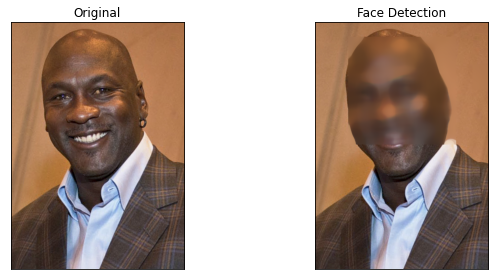

In [91]:
haarcascade = '/content/drive/MyDrive/PCVK/haarcascades/haarcascade_frontalface_default.xml'
blurred_image = blur_face(haarcascade, mjordan)
show_image(mjordan, blurred_image)